In [2]:
import pandas as pd 
import numpy as np 
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer #filling null values for every columns
from sklearn.base import BaseEstimator , TransformerMixin
from sklearn.preprocessing import StandardScaler #standadization of data 
from sklearn.preprocessing import LabelEncoder , OneHotEncoder

## Import Calender and Dataframe

In [14]:
df = pd.read_excel('year.xlsx')
df['date'] = pd.to_datetime(df['date'])
#df.sort_values(by = 'date' , ignore_index = True)
cd = pd.read_excel('calender.xlsx')
cd1 = pd.read_excel('Calendar1401.xlsx')

In [19]:
cd1['date'] = pd.to_datetime(cd1['Miladi_Date'])

In [21]:
def change_format (x):
    
    day = str(int(x.split('/')[1]))
    month = str(int(x.split('/')[0]))
    year = x.split('/')[2]
    
    return dt.datetime(int(year) , int(month) , int(day))



In [22]:
cd['date'] = cd['Miladi_Date'].apply(change_format)

In [23]:
cd= pd.concat([cd , cd1])

In [24]:
merged = df.merge(cd , how='left' , on = 'date' )
selected_merged = merged[['date' , 'orders' , 'DayState']]
selected_merged = selected_merged.sort_values(by = 'date' , ignore_index = True)

In [27]:
# Manage Holidays
def holiday_manage(serie):
    for i in range(1,len(serie.index)-2):
        if serie[i]=='NormalDay' and serie[i-1] == 'Holiday' and serie[i+1] == 'Holiday':
            selected_merged.loc[i , 'DayState'] = 'Between'
        if serie[i]=='NormalDay' and serie[i+1] == 'Holiday' and serie[i+2] == 'Holiday':
            selected_merged.loc[i , 'DayState'] = 'PreHoliday'
            
holiday_manage(selected_merged['DayState'])

In [28]:
# Adding Seasons
def season(df):
    df['season'] = 0
    for i in df.index:
        if df.loc[i , 'date'].month>= 3 and df.loc[i , 'date'].month<= 5:
            df.loc[i , 'season'] = 'spring'
        elif df.loc[i , 'date'].month>= 6 and df.loc[i , 'date'].month<= 8:
            df.loc[i , 'season'] = 'summer'
        elif df.loc[i , 'date'].month>= 9 and df.loc[i , 'date'].month<= 11:
            df.loc[i , 'season'] = 'fall'
        else:
            df.loc[i , 'season'] = 'winter'  
season(selected_merged)

In [29]:
# Add Day Name
selected_merged['dayofweek'] = selected_merged['date'].dt.dayofweek

## Select Features

In [30]:
selected_merged.groupby('season')['orders'].mean()

season
fall      156485.285714
spring    145396.608696
summer    144030.641304
winter    152792.388889
Name: orders, dtype: float64

In [31]:
selected_merged.groupby('DayState')['orders'].mean()

DayState
Between       147645.666667
Holiday       134600.102941
NormalDay     153421.202091
PreHoliday    141593.428571
Name: orders, dtype: float64

In [32]:
dict = {0:'sat' , 1:'sun' , 2:'mon' , 3:'tue' , 4:'wen' , 5:'thu' , 6:'fri'}
for i in range(0,7):
    filt = selected_merged['dayofweek'] == i
    print(f'Average number of orders in {dict[i]} are equal to {np.round(selected_merged.loc[filt , "orders"].mean() , 2)} ')

Average number of orders in sat are equal to 153496.46 
Average number of orders in sun are equal to 153006.35 
Average number of orders in mon are equal to 156449.79 
Average number of orders in tue are equal to 151488.92 
Average number of orders in wen are equal to 139923.83 
Average number of orders in thu are equal to 143547.35 
Average number of orders in fri are equal to 149757.67 


In [34]:
selected_merged['dayofweek'] = selected_merged['dayofweek'].apply(lambda x: 'First half' if x<=3 else 'Second half')

In [35]:
selected_merged.groupby('dayofweek')['orders'].mean()

dayofweek
First half     153610.379808
Second half    144381.044586
Name: orders, dtype: float64

## Encoding

In [36]:
df = selected_merged.copy()

In [37]:
df['DayState'] = df['DayState'].map({'Holiday' : 0 , 'PreHoliday' : 1 , 'Between' : 1 , 'NormalDay':1})

In [38]:
encoder_hot = OneHotEncoder(sparse =False) #sparse =false is for null values
data_cat_hot_tmp = encoder_hot.fit_transform(df[['dayofweek' , 'season']])
data_cat_hot=pd.DataFrame(data_cat_hot_tmp)
data_cat_hot.columns = encoder_hot.get_feature_names(['week' , 'season'])
data_cat_hot.head()
final = pd.concat([df , data_cat_hot] , axis=1)
final.head()

,date,orders,DayState,season,dayofweek,week_First half,week_Second half,season_fall,season_spring,season_summer,season_winter
0,2021-06-04,115840,0,summer,Second half,0.0,1.0,0.0,0.0,1.0,0.0
1,2021-06-05,114942,0,summer,Second half,0.0,1.0,0.0,0.0,1.0,0.0
2,2021-06-06,124147,0,summer,Second half,0.0,1.0,0.0,0.0,1.0,0.0
3,2021-06-07,135901,1,summer,First half,1.0,0.0,0.0,0.0,1.0,0.0
4,2021-06-08,140818,1,summer,First half,1.0,0.0,0.0,0.0,1.0,0.0


## Purification

In [92]:
final.dropna(axis= 0 , how='any' , inplace=True) 

In [96]:
final = final.drop(['date' , 'season' , 'dayofweek'] , axis= 1)

## Correlation Finder 

In [39]:
#standard correlation coefficient (linear) [-1,1] 1= 100% and -1=100% opp coeffucient
corr_matrix =final.corr()
corr_matrix['orders'].sort_values(ascending=False)

orders              1.000000
DayState            0.435577
week_First half     0.276559
season_fall         0.238745
season_winter       0.109133
season_spring      -0.149110
season_summer      -0.197103
week_Second half   -0.276559
Name: orders, dtype: float64

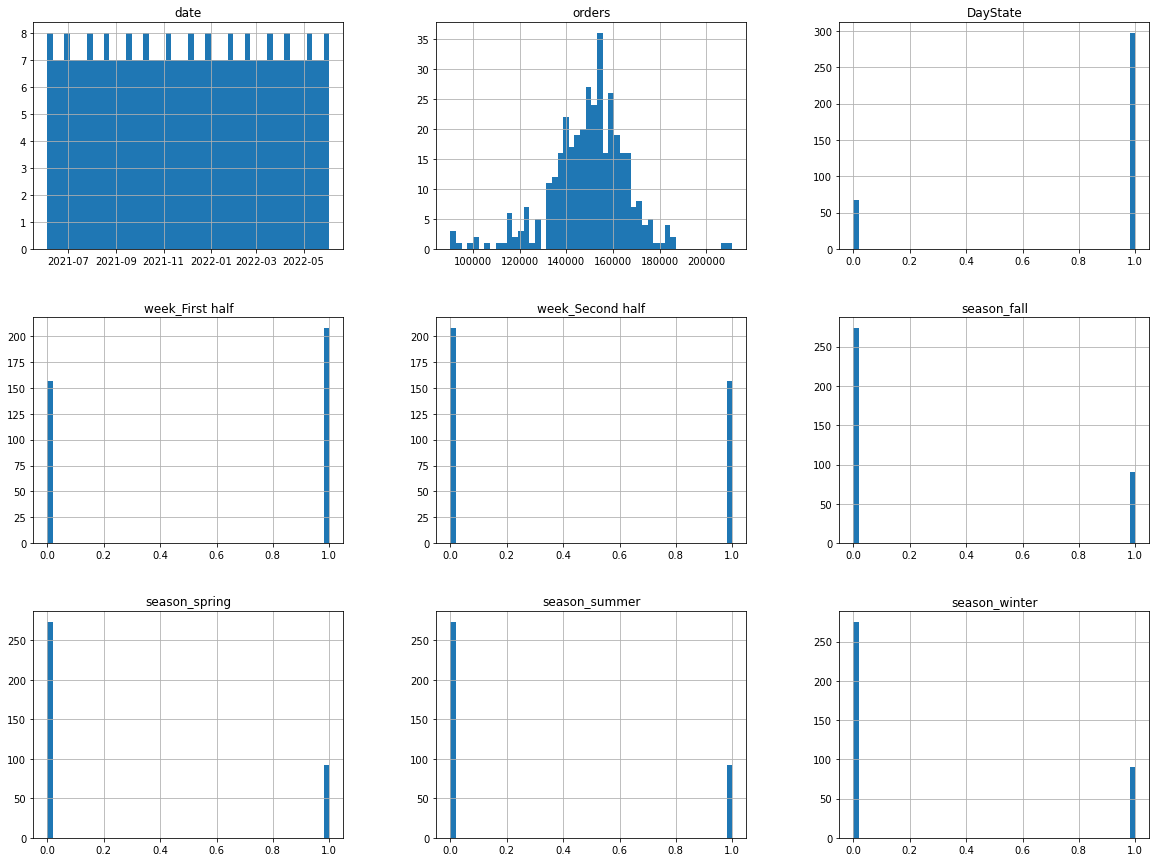

In [40]:
final.hist(bins=50,figsize=(20,15))
plt.show()

# Machine Learning (Train_Test split)

In [104]:
train_set , test_set = train_test_split(final, test_size = 0.2 , random_state=42)
print(train_set.shape[0] , test_set.shape[0])

232 58


In [105]:
prepared_df = train_set.drop('orders' , axis = 1)
target = train_set['orders']

## Model Selection

In [108]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [109]:
#================================== linear ** Regression ==================================#
lin_reg = LinearRegression()
lin_reg.fit(prepared_df,target)

order_predications = lin_reg.predict(prepared_df)
lin_mse = mean_squared_error(target ,order_predications )
lin_rmse = np.sqrt(lin_mse)
lin_rmse

11492.355080234594

In [110]:
#================================== DecisionTree ** Regression ==================================#
tree_reg = DecisionTreeRegressor()
tree_reg.fit(prepared_df,target)  
order_predications = tree_reg.predict(prepared_df)
lin_mse = mean_squared_error(target ,order_predications )
lin_rmse = np.sqrt(lin_mse)
lin_rmse

11078.135150203689

In [111]:
#================================== RandomForest ** Regression ==================================#
forest_reg = RandomForestRegressor()
forest_reg.fit(prepared_df,target) 
order_predications = forest_reg.predict(prepared_df)
lin_mse = mean_squared_error(target ,order_predications )
lin_rmse = np.sqrt(lin_mse)
lin_rmse

11085.908860276568

## Test Model with Test_Set

In [119]:
X = test_set.drop('orders' , axis = 1 )
y = test_set['orders']

In [128]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X,y) 

DecisionTreeRegressor()

In [129]:
final_predications = tree_reg.predict(X)
final_mse = mean_squared_error(y , final_predications)
final_rmse = np.sqrt(final_mse)
final_mse

112397928.01966338